## Sherbrooke Learning

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train
from rl_algos.ppo_continuous import PPO_make_train

from utils import photon_env_dicts, plot_learning

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Sherbrooke Params and RL Params

tau_0 = 0.783
kappa = 14.31
chi = 0.31 * 2. * jnp.pi
kerr = 0.00
n0 = 53.8
res_amp_scaling = 1/0.348
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.1
gamma_I = 1/362.9
photon_gamma = 1/4000
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
apply_bandwidth_constraint = False
num_t1 = 9.0
photon_weight = 12.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 4000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 53.8
Actual Max Photons: 53.711451977836106


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -29.304000000000002
max pF: 1.478
max photon: 43.87
photon time: 0.9699000000000001
smoothness: 0.00954
bandwidth: 40.469
global update: 200
reward: -18.06
max pF: 1.559
max photon: 45.567
photon time: 0.7407
smoothness: 0.007876
bandwidth: 35.941
global update: 300
reward: -6.859
max pF: 1.592
max photon: 44.647
photon time: 0.7929
smoothness: 0.006215
bandwidth: 33.693
global update: 400
reward: 0.762
max pF: 1.661
max photon: 46.007
photon time: 0.8593000000000001
smoothness: 0.005013999999999999
bandwidth: 31.211000000000002
global update: 500
reward: 7.625
max pF: 1.758
max photon: 49.772
photon time: 0.7518
smoothness: 0.003986
bandwidth: 26.326
global update: 600
reward: 13.07
max pF: 1.794
max photon: 49.965
photon time: 0.6839000000000001
smoothness: 0.0035139999999999998
bandwidth: 24.096
global update: 700
reward: 16.830000000000002
max pF: 1.809
max photon: 50.015
photon time: 0.6318
smoothness: 0.003011
bandwidth: 2

In [5]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]

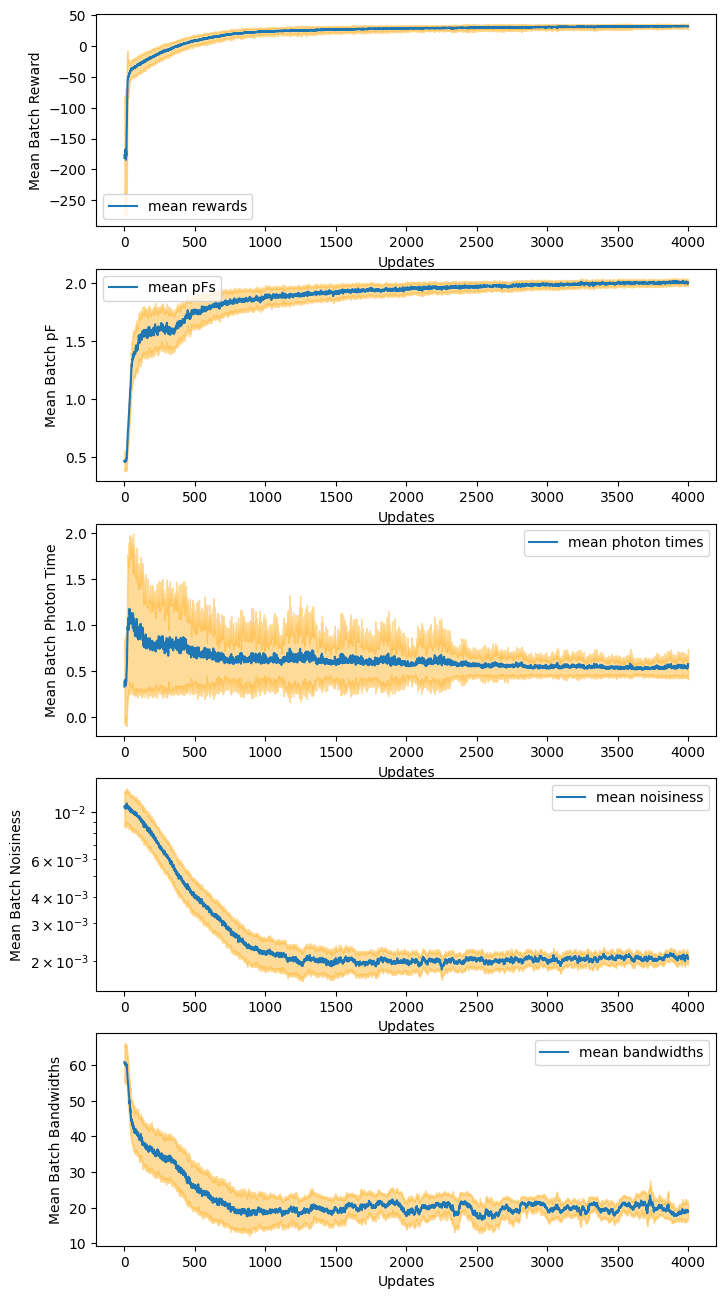

In [6]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

In [7]:
env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

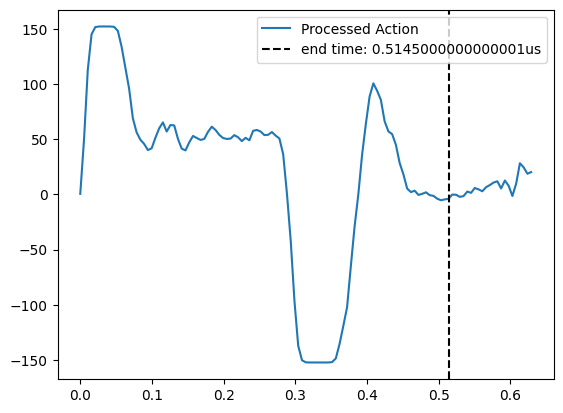

In [10]:
final_action = -actions[-1, 0]
final_processed_action = env.prepare_action(final_action)
end_time = jnp.round(photon_times[-1, 0], 4)

# plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.axvline(x=end_time, linestyle='dashed', color='black', label=f'end time: {end_time}us')
plt.legend()
plt.show()

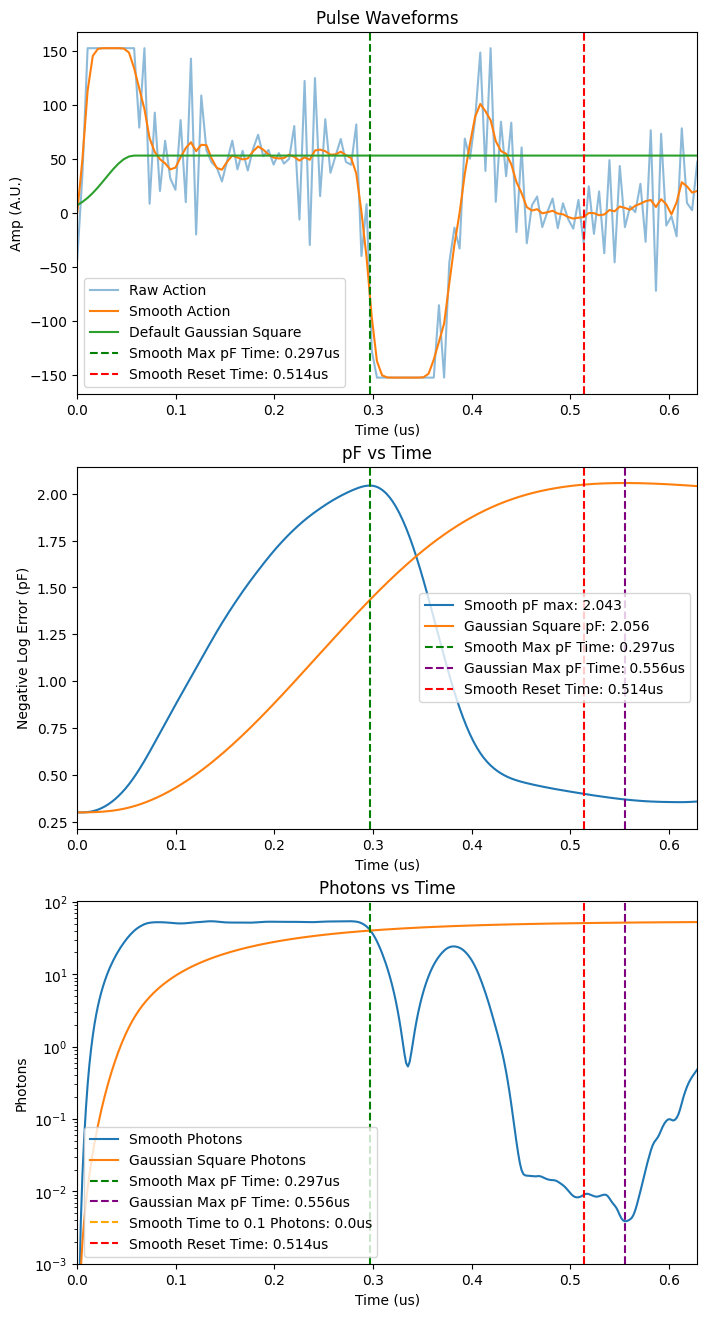

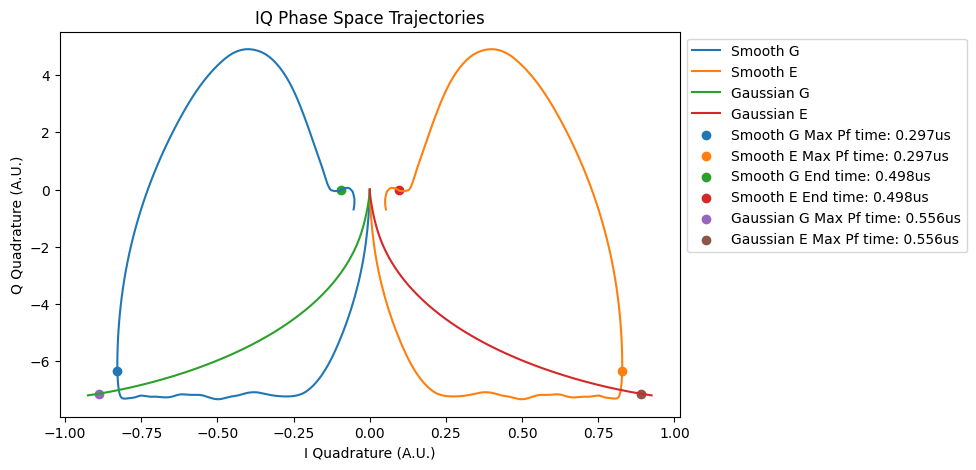

In [11]:
env.rollout_action(_rng, final_action, photon_log_scale=True)

## Sherbrooke A3R Waveform

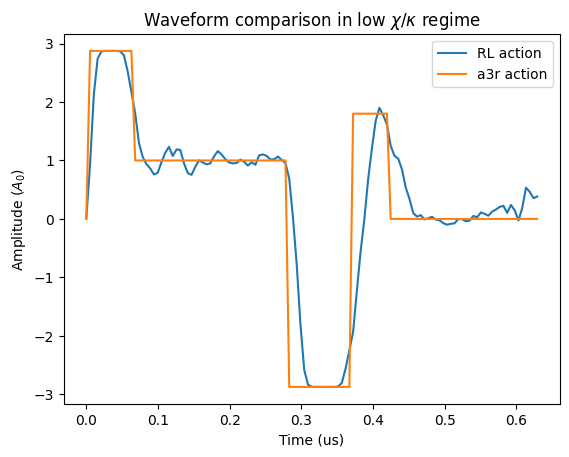

In [36]:
# Making A3R Waveform, consisting of:
# Single Tone Ring-Up
# Single Tone Readout
# Two Tone Reset

ts = env.ts_action
amp_1 = env.mu
amp_r = 1.0
amp_reset_1 = -env.mu
amp_reset_2 = 1.8
dur_1 = 0.065
dur_r = 0.215
dur_reset_1 = 0.090
dur_reset_2 = 0.050

def add_single_tone(ts, t0, pulse, amp, dur):
    tone_waveform = jnp.heaviside(ts - t0, 0.) * jnp.heaviside(t0 + dur - ts, 1.)
    t0 += dur
    return t0, pulse + tone_waveform * amp

normed_sherbrooke_action = final_processed_action / env.a0

t0_a3r = 0.
a3r_action = jnp.zeros_like(ts)
t0_a3r, a3r_action = add_single_tone(ts, t0_a3r, a3r_action, amp_1, dur_1)
t0_a3r, a3r_action = add_single_tone(ts, t0_a3r, a3r_action, amp_r, dur_r)
t0_a3r, a3r_action = add_single_tone(ts, t0_a3r, a3r_action, amp_reset_1, dur_reset_1)
t0_a3r, a3r_action = add_single_tone(ts, t0_a3r, a3r_action, amp_reset_2, dur_reset_2)

plt.plot(ts, normed_sherbrooke_action, label='RL action')
plt.plot(ts, a3r_action, label='a3r action')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude ($A_0$)')
plt.title('Waveform comparison in low $\chi/\kappa$ regime')
plt.legend()
plt.show()

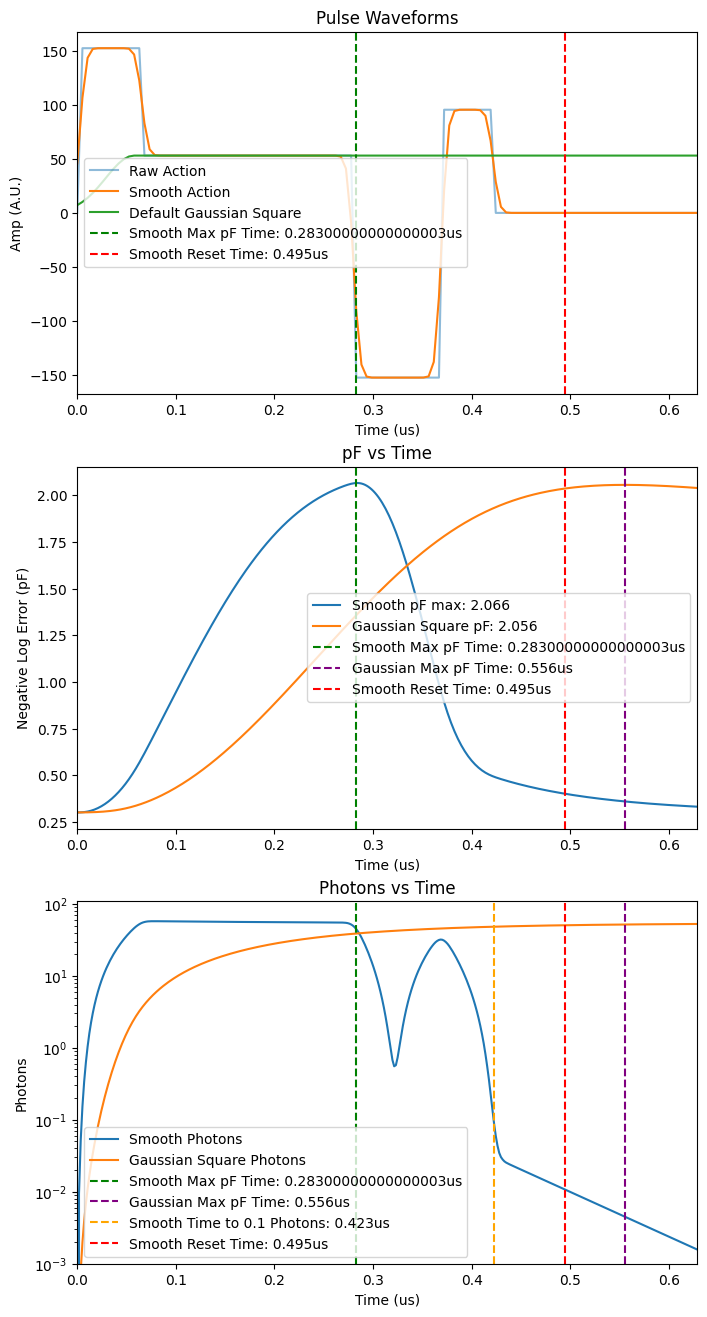

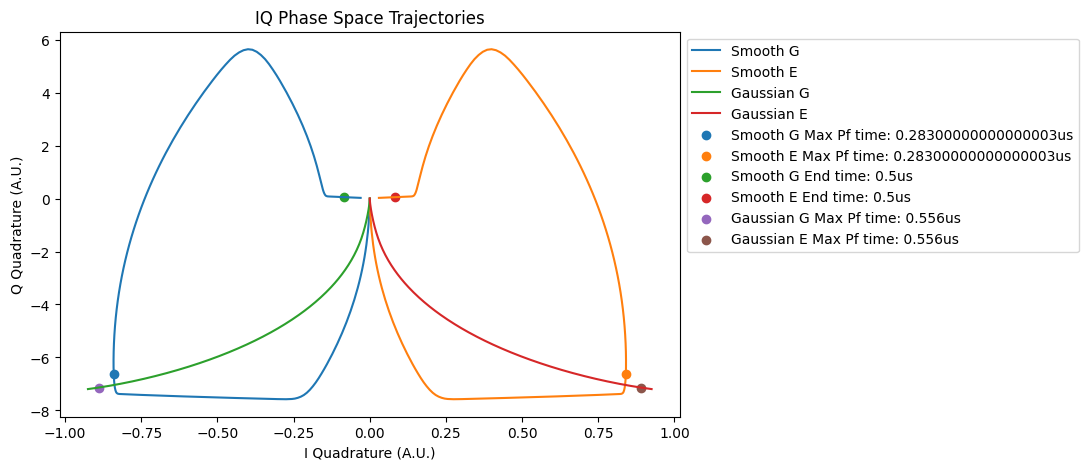

In [38]:
# Plotting A3R Action Results

env.rollout_action(_rng, a3r_action, photon_log_scale=True)

In [43]:
# Comparing A3R vs Sherbrooke RL IQ Trajectories

prepped_a3r_action = env.prepare_action(a3r_action)
prepped_sherbrooke_action = final_processed_action

a3r_res = env.calc_results(-prepped_a3r_action)
sher_res = env.calc_results(-prepped_sherbrooke_action)

a3r_g = a3r_res[:, 0] + 1.0j * a3r_res[:, 1]
a3r_e = a3r_res[:, 2] + 1.0j * a3r_res[:, 3]

sher_g = sher_res[:, 0] + 1.0j * sher_res[:, 1]
sher_e = sher_res[:, 2] + 1.0j * sher_res[:, 3]

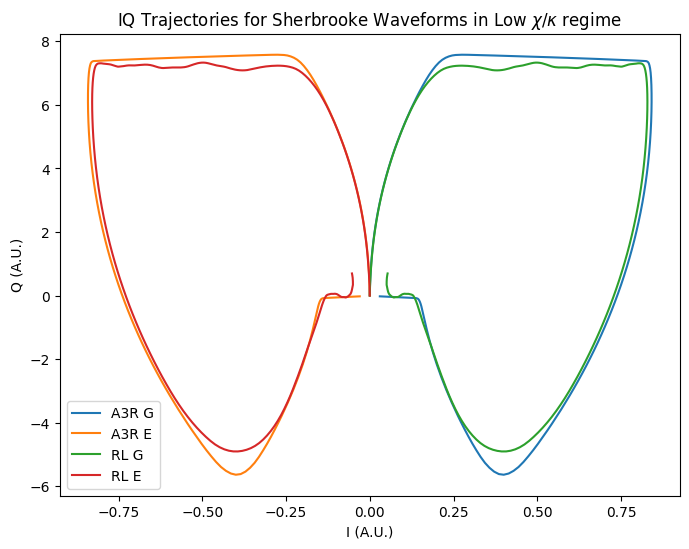

In [54]:
# Plotting Trajectories

plt.figure(figsize=(8.0, 6.0))

plt.plot(a3r_g.real, a3r_g.imag, label='A3R G')
plt.plot(a3r_e.real, a3r_e.imag, label='A3R E')
plt.plot(sher_g.real, sher_g.imag, label='RL G')
plt.plot(sher_e.real, sher_e.imag, label='RL E')
plt.xlabel('I (A.U.)')
plt.ylabel('Q (A.U.)')
plt.title('IQ Trajectories for Sherbrooke Waveforms in Low $\chi/\kappa$ regime')
plt.legend()
plt.show()

## CLEAR Regime Waveform

In [72]:
# CLEAR Regime Params
tau_0 = 1.0
kappa = 1/0.14
chi = 2.6 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
n0 = 3.6
res_amp_scaling = 1/0.5
actual_max_photons = n0 * (1. - jnp.exp(-0.5 * kappa * tau_0)) ** 2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 0.5
gamma_I = 1/140
num_t1 = 4.0
photon_gamma = 1/1000
init_fid = 1 - 1e-4

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.8
bandwidth_coeff = 0.0
apply_bandwidth_constraint = False
photon_weight = 4.0
shot_noise_std = 0.0
standard_fid = 0.99

clear_env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 4000
clear_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    # "KERNEL_SIZE": 15,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": clear_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 3.6
Actual Max Photons: 3.4004130149706335


In [73]:
clear_env = photon_env_dicts()[clear_config["ENV_NAME"]](**clear_config["ENV_PARAMS"])

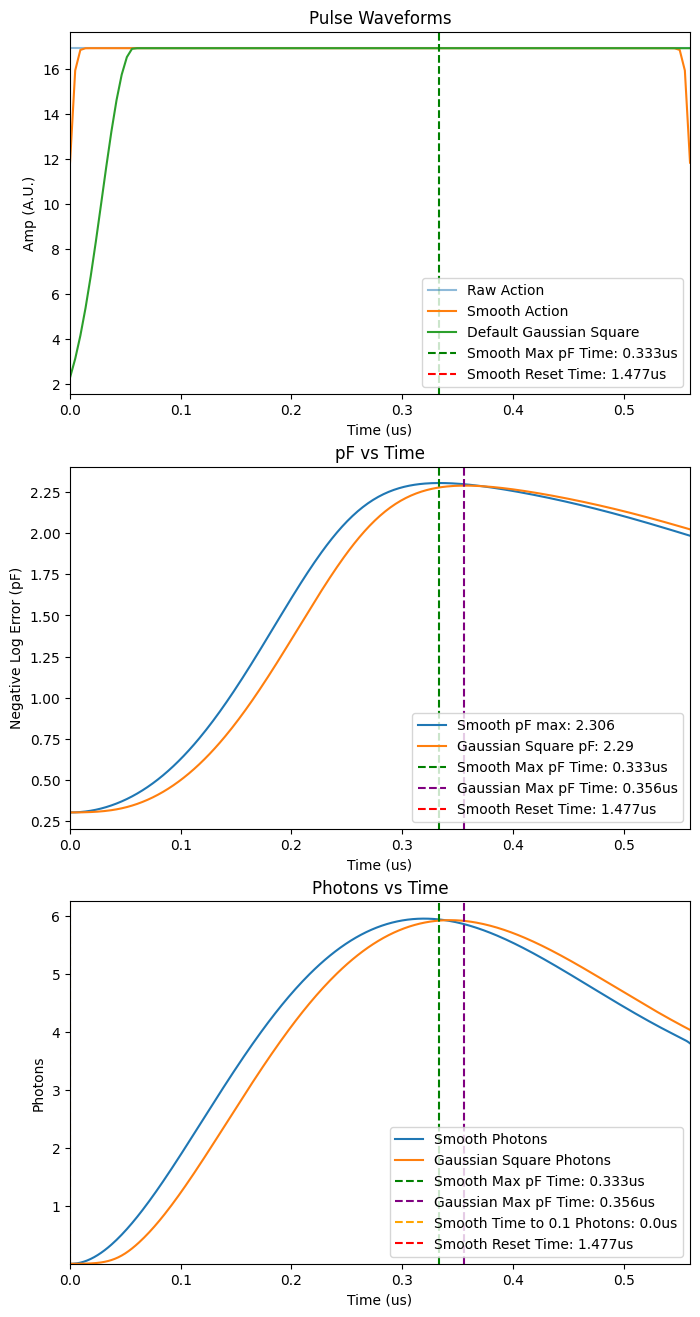

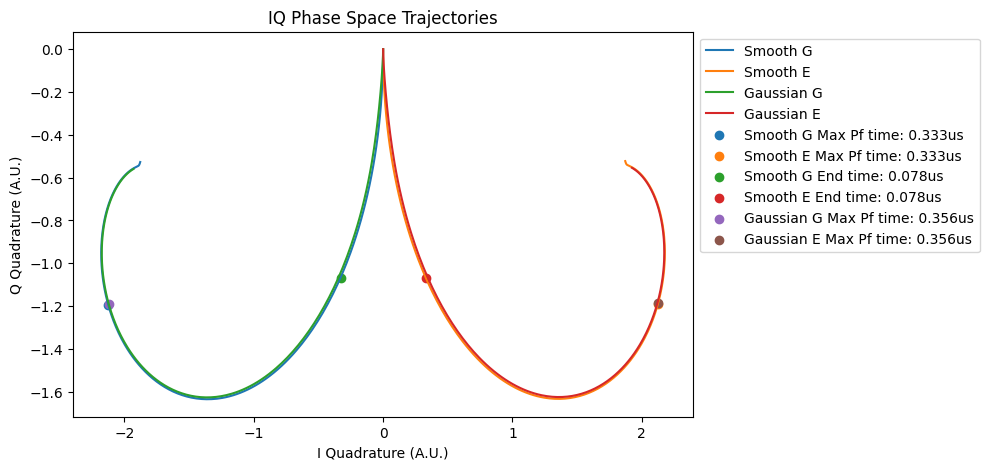

In [74]:
standard_action = jnp.ones_like(clear_env.ts_action)

clear_env.rollout_action(_rng, standard_action, bound_plots=True)

In [75]:
clear_train = jit(PPO_make_train(clear_config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
clear_result = clear_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -58.845
max pF: 1.6
max photon: 3.2960000000000003
photon time: 0.9219
smoothness: 0.015545999999999999
bandwidth: 1.543
global update: 200
reward: -36.226
max pF: 1.61
max photon: 3.263
photon time: 0.9136000000000001
smoothness: 0.011961
bandwidth: 5.154
global update: 300
reward: -19.503
max pF: 1.6580000000000001
max photon: 3.271
photon time: 0.8542000000000001
smoothness: 0.009165
bandwidth: 6.219
global update: 400
reward: -8.555
max pF: 1.6460000000000001
max photon: 3.129
photon time: 0.7298
smoothness: 0.00748
bandwidth: 6.268
global update: 500
reward: 3.624
max pF: 1.723
max photon: 3.294
photon time: 0.7074
smoothness: 0.005647
bandwidth: 5.638
global update: 600
reward: 12.519
max pF: 1.7570000000000001
max photon: 3.383
photon time: 0.6319
smoothness: 0.004438
bandwidth: 5.548
global update: 700
reward: 17.686
max pF: 1.7910000000000001
max photon: 3.447
photon time: 0.6246
smoothness: 0.003528
bandwidth: 5.963
gl

In [76]:
# Extracting Results

clear_metrics = clear_result["metrics"]

c_rewards = clear_metrics["reward"]
c_max_pFs = clear_metrics["max pF"]
c_max_photons = clear_metrics["max photon"]
c_photon_times = clear_metrics["photon time"]
c_smoothnesses = clear_metrics["smoothness"]
c_bandwidths = clear_metrics["bandwidth"]
c_actions = clear_metrics["action"]

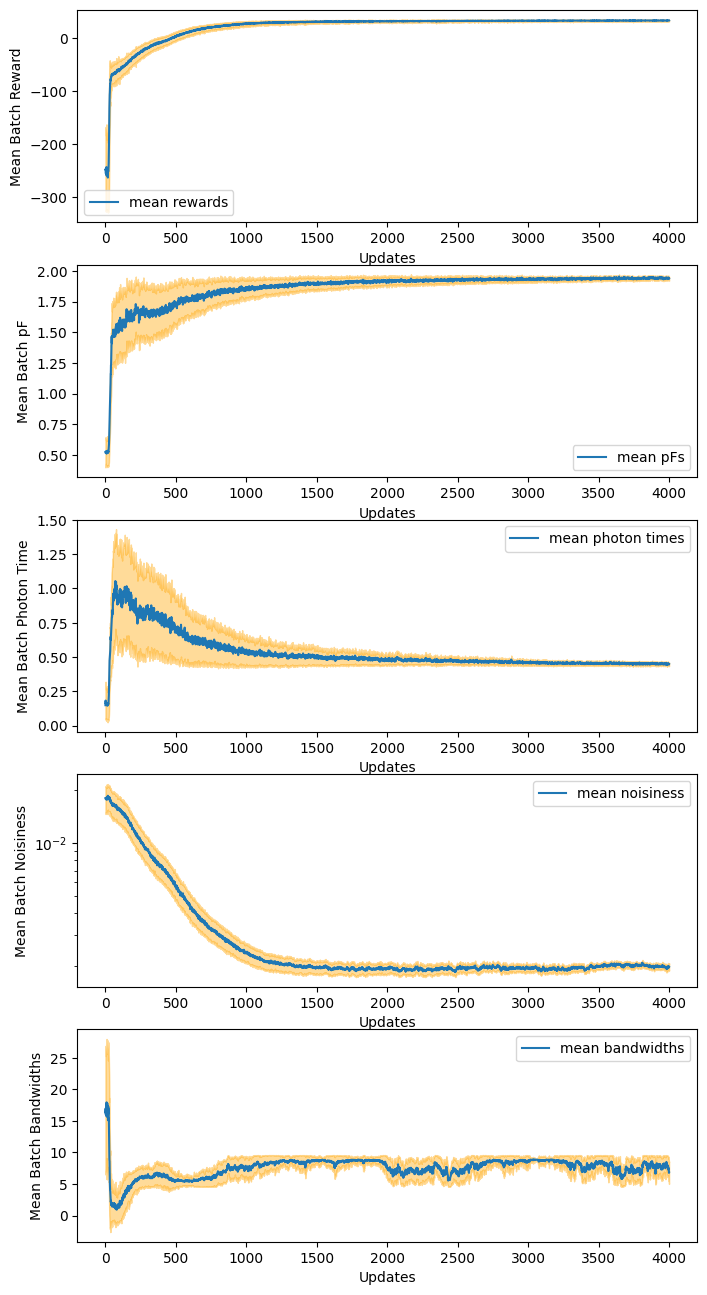

In [77]:
plot_learning(
    rewards=c_rewards,
    max_pFs=c_max_pFs,
    photon_times=c_photon_times,
    smoothnesses=c_smoothnesses,
    bandwidths=c_bandwidths,
)

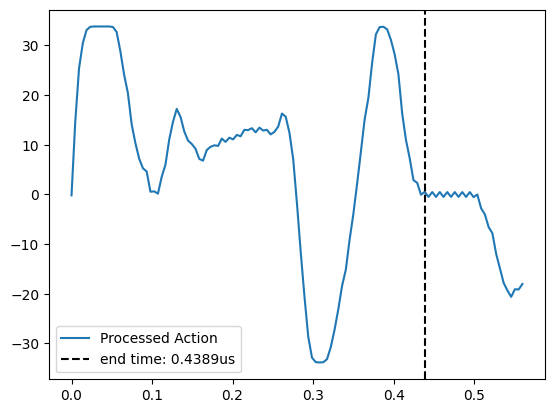

In [79]:
final_clear_action = c_actions[-1, 0]
final_clear_processed_action = clear_env.prepare_action(final_clear_action)
c_end_time = jnp.round(c_photon_times[-1, 0], 4)

# plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(clear_env.ts_action, final_clear_processed_action, label='Processed Action')
plt.axvline(x=c_end_time, linestyle='dashed', color='black', label=f'end time: {c_end_time}us')
plt.legend()
plt.show()

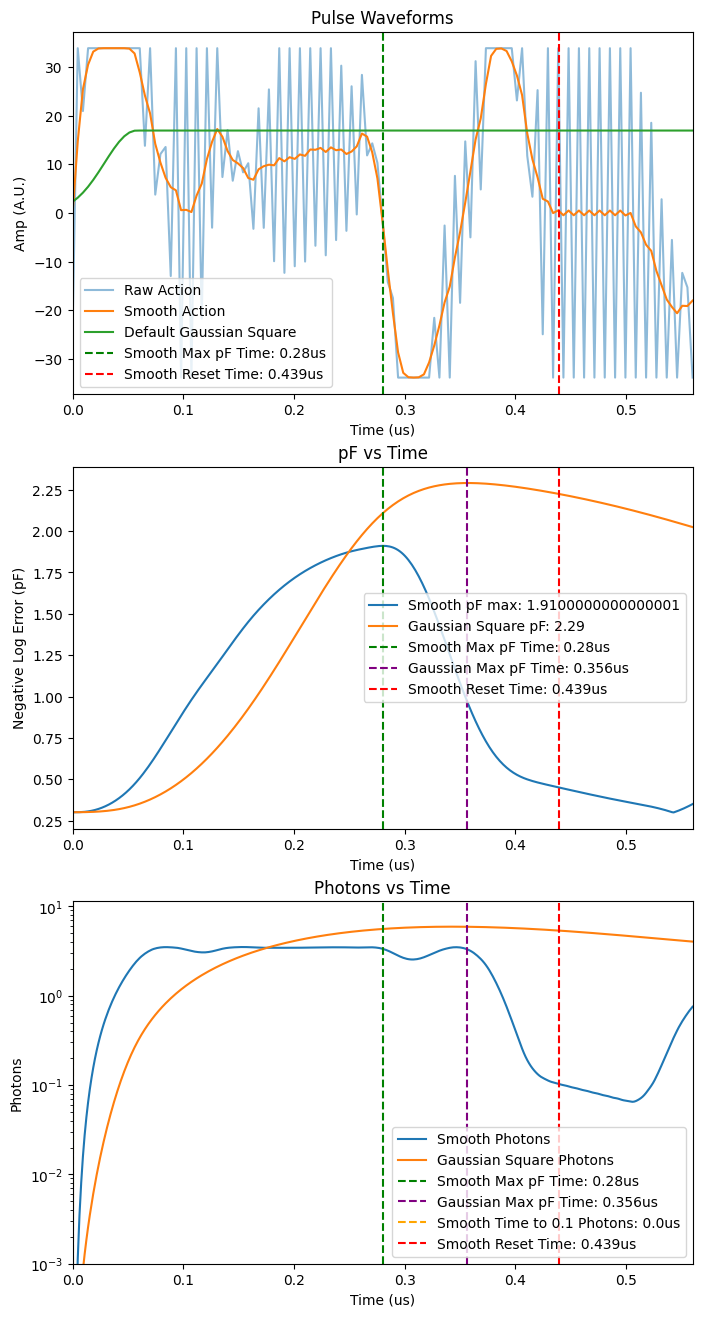

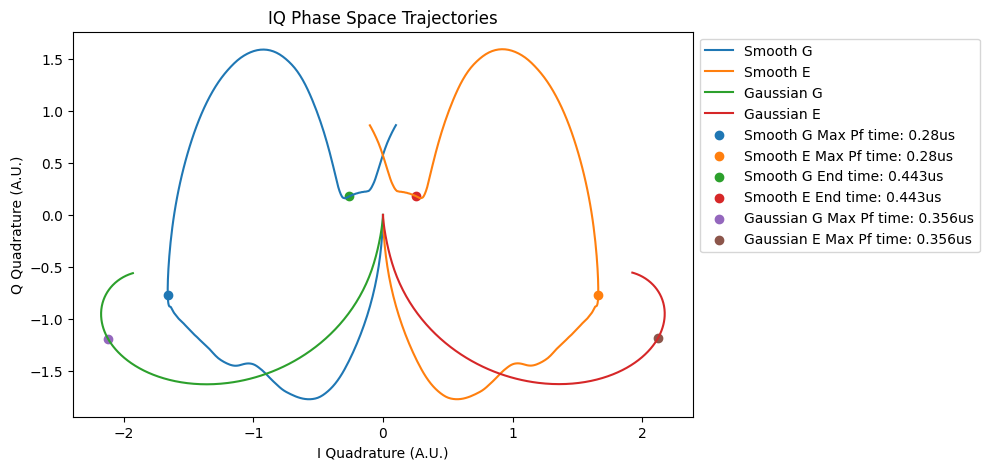

In [80]:
clear_env.rollout_action(_rng, final_clear_action, photon_log_scale=True)

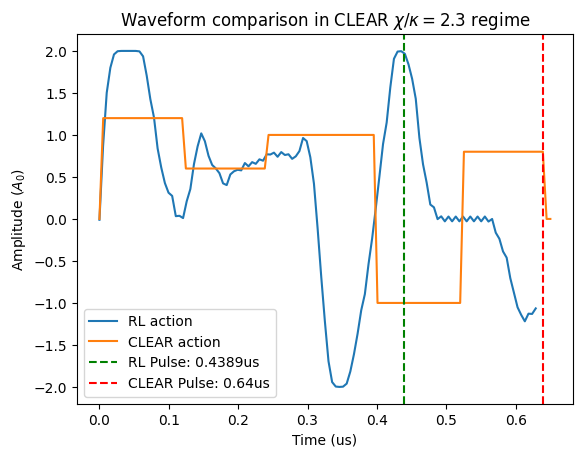

In [96]:
# Making CLEAR Waveform, consisting of:
# Two Tone Ring-Up, Both Tones of 150ns
# Single Tone Readout
# Two Tone Reset, Both Tones of 150ns

clear_ts = jnp.linspace(0., 0.65, 121)
amp_1 = 1.2
amp_2 = 0.6
amp_r = 1.0
amp_reset_1 = -1.0
amp_reset_2 = 0.8
clear_dur_tone = 0.12
clear_dur_readout = 0.16

def add_single_tone(ts, t0, pulse, amp, dur):
    tone_waveform = jnp.heaviside(ts - t0, 0.) * jnp.heaviside(t0 + dur - ts, 1.)
    t0 += dur
    return t0, pulse + tone_waveform * amp

normed_clear_rl_action = final_clear_processed_action / clear_env.a0

t0_clear = 0.
clear_action = jnp.zeros_like(ts)
t0_clear, clear_action = add_single_tone(clear_ts, t0_clear, clear_action, amp_1, clear_dur_tone)
t0_clear, clear_action = add_single_tone(clear_ts, t0_clear, clear_action, amp_2, clear_dur_tone)
t0_clear, clear_action = add_single_tone(clear_ts, t0_clear, clear_action, amp_r, clear_dur_readout)
t0_clear, clear_action = add_single_tone(clear_ts, t0_clear, clear_action, amp_reset_1, clear_dur_tone)
t0_clear, clear_action = add_single_tone(clear_ts, t0_clear, clear_action, amp_reset_2, clear_dur_tone)

clear_end_time = 0.64

plt.plot(ts, normed_clear_rl_action, label='RL action')
plt.plot(clear_ts, clear_action, label='CLEAR action')
plt.axvline(x=c_end_time, label=f'RL Pulse: {c_end_time}us', linestyle='dashed', color='green')
plt.axvline(x=clear_end_time, label=f'CLEAR Pulse: {clear_end_time}us', linestyle='dashed', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude ($A_0$)')
plt.title('Waveform comparison in CLEAR $\chi/\kappa = 2.3$ regime')
plt.legend()
plt.show()

In [99]:
# Comparing CLEAR vs RL IQ Trajectories

prepped_clear_action = clear_env.prepare_action(clear_action)
prepped_rl_action = final_clear_processed_action

clear_res = clear_env.calc_results(-prepped_clear_action)
rl_res = clear_env.calc_results(-prepped_rl_action)

clear_g = clear_res[:, 0] + 1.0j * clear_res[:, 1]
clear_e = clear_res[:, 2] + 1.0j * clear_res[:, 3]

rl_g = rl_res[:, 0] + 1.0j * rl_res[:, 1]
rl_e = rl_res[:, 2] + 1.0j * rl_res[:, 3]

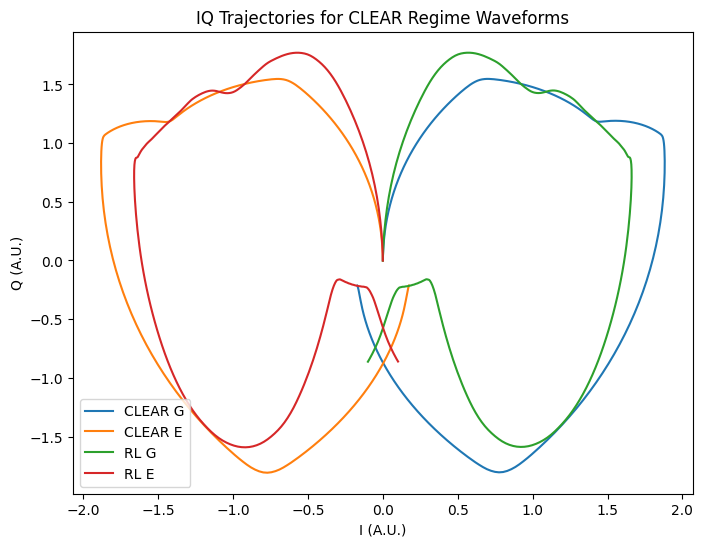

In [100]:
# Plotting Trajectories

plt.figure(figsize=(8.0, 6.0))

plt.plot(clear_g.real, clear_g.imag, label='CLEAR G')
plt.plot(clear_e.real, clear_e.imag, label='CLEAR E')
plt.plot(rl_g.real, rl_g.imag, label='RL G')
plt.plot(rl_e.real, rl_e.imag, label='RL E')
plt.xlabel('I (A.U.)')
plt.ylabel('Q (A.U.)')
plt.title('IQ Trajectories for CLEAR Regime Waveforms')
plt.legend()
plt.show()

## Saving Data

In [103]:
import pandas as pd

df_waveforms = pd.DataFrame({
    'sherbrooke rl waveform': final_processed_action / env.a0,
    'A3R waveform': a3r_action,
    'clear rl waveform': final_clear_processed_action / clear_env.a0,
    'CLEAR waveform': clear_action,
})
df_waveforms.to_csv('fig 3 waveforms')
df_trajs = pd.DataFrame({
    'sherbrooke rl traj g': sher_g,
    'sherbrooke rl traj e': sher_e,
    'A3R traj g': a3r_g,
    'A3R traj e': a3r_e,
    'clear rl traj g': rl_g,
    'clear rl traj e': rl_e,
    'CLEAR traj g': clear_g,
    'CLEAR traj e': clear_e,
})
df_trajs.to_csv('fig 3 trajectories')